# A Minimal Folw-Matching Based Image Generator

This file build a basic toy-data image generator based on flow-matching based method

The file is adapted from the [mit diffusion model course](https://diffusion.csail.mit.edu/), and the repository is at [here](https://github.com/eje24/iap-diffusion-labs)

The Procedure is as follows:
- 1. Samples from "data" and transform the data into tensors (the data is generated by sample-generator, i.e. the class "Sampleable")
- 2. Samples from the simple distribution, and use NN to learn the vector field
- 3. Samples from the simple distribution, and use the learned vector field to make idea images

In [465]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
import torchvision.utils as vutils
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Preparation done. The device is: ", device)

Preparation done. The device is:  cuda


## Overview

This notebook implements a complete toy framework for flow matching in 2D, designed to visualize and test the behavior of learned vector fields between simple source and target distributions.

<br>

### Part 1. Sampleable Distributions

We define five configurable 2D distributions from which samples can be drawn:

1. **Gaussian** — arbitrary mean and covariance.  
2. **Gaussian Mixture** — mixture of Gaussians with tunable parameters.  
3. **Moons** — 2D crescent-shaped dataset.  
4. **Checkerboard** — discrete alternating square pattern.  
5. **Disk** — uniform distribution over a 2D circular region.

Each sampleable produces tensors of shape `(batch_size, dim)`, where `dim = tunnel * Width * Height`.

This part is too tedious and the code for `Part 1` is written by AI.

You can simply skip it as long as you know that `sampleable.sample()` will return a tensor which represents an image(i.e., shape(dim, )) and `sampleablt.batch_samples(batch_size)` will return a tensor of shape(batch_size, dim) 

You can manually adjust the dim, but the default value has been set. Check these classes yourself

<br>

### Part 2. ODE Simulators

Two numerical solvers are implemented to simulate trajectories based on learned vector fields:

1. **Euler Method** — first-order integrator.  
2. **Heun’s Method** — second-order integrator (improved Euler scheme).

<br>

### Part 3. Conditional Gaussian Vector Fields

We define two classes of conditional vector fields parameterized by neural networks and constrained by:

1. $ \alpha(t)^2 + \beta(t)^2 = 1 $  
2. $ \alpha(t) + \beta(t) = 1 $

These determine the blending between source and target scores in the learned velocity field.

<br>

### Part 4. Neural Network Architecture

The core of the vector field $ u_\theta(x, t) $ is a Multi-Layer Perceptron (MLP). The hidden structure is customizable.

<br>

### Part 5. Training

1. **Sample from Target**: Draw training samples $ x_1 \sim \text{Sampleable A} $.  
2. **Sample from Source**: Draw base samples $ x_0 \sim \text{Sampleable B} $ (usually standard Gaussian).  
3. **Learn Vector Field**: Train $ u_\theta $ to match source and target via flow matching loss.  

<br>

### Part 6. Simulatioin and Visualization
   - Plot example target samples.
   - Apply the learned flow (via integration) to new source samples.
   - Plot the resulting generated samples for qualitative comparison.

This setup allows modular experimentation with different distributions, integrators, and network structures.

# Part1: The Sampleables

**Note that this part is tedious and is too difficult for me. So, thanks to Gemini**

#### The abstract class and the helper function

In [466]:
# --- Helper Function to Render Points to Image ---
def _render_points_to_image(points: torch.Tensor, image_size: int, scale: float, device: torch.device) -> torch.Tensor:
    """
    Renders 2D points onto a square grayscale image.
    Points are assumed to be in a range relative to the scale, e.g., [-scale, scale].
    The output image will have values between 0 (empty) and 1 (point present).

    Args:
        points: A tensor of 2D points with shape (N, 2).
        image_size: The desired height and width of the square image (e.g., 64).
        scale: The maximum absolute coordinate value from the data source (e.g., 5.0).
               Used to normalize points into the [0, 1] image coordinate system.
        device: The device (cpu or cuda) for the output tensor.

    Returns:
        A flattened tensor representing a single grayscale image of shape (image_size * image_size,).
    """
    img = torch.zeros((image_size, image_size), device=device, dtype=torch.float32)

    # Normalize points to [0, 1] range for image coordinates
    # Original points are assumed to be in [-scale, scale] range.
    normalized_points = (points + scale) / (2 * scale)

    # Convert to pixel coordinates
    # Clamp to ensure points are within image bounds [0, image_size - 1]
    pixel_x = torch.clamp((normalized_points[:, 0] * image_size).long(), 0, image_size - 1)
    pixel_y = torch.clamp((normalized_points[:, 1] * image_size).long(), 0, image_size - 1)

    # Set pixels where points exist to 1.0
    # Using advanced indexing to efficiently set pixels
    img[pixel_y, pixel_x] = 1.0 # Note: (y, x) for image indexing

    # --- MODIFIED: Flatten the image before returning ---
    return img.view(image_size * image_size) # Return flattened shape (H*W,)


# --- Abstract Class Sampleable Definition ---
class Sampleable(ABC):
    # The class that can be sampled from

    @abstractmethod
    def sample(self) -> torch.Tensor:
        # Return a single image sample of flattened shape (channels * height * width,)
        pass

    @abstractmethod
    def batch_samples(self, num_samples: int) -> torch.Tensor:
        # Return a batch of samples where batch_size = num_samples.
        # Shape: (batch_size, channels * height * width)
        pass

    @property
    @abstractmethod
    def dim(self) -> int:
        # Return the flattened dimension of a single sample (e.g., 1 * 64 * 64 = 4096)
        pass

    @property
    @abstractmethod
    def image_shape(self) -> Tuple[int, int, int]:
        # Return the original image shape (channels, height, width) for conceptual understanding/reshaping
        pass

#### The Gaussian Sampleable Class

In [467]:
class GaussianSampleable(Sampleable):
    """
    Implementation of a 2D Gaussian distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, mean: Optional[torch.Tensor] = None,
                 covariance: Optional[torch.Tensor] = None, scale: float = 5.0, points_per_image: int = 50000):
        """
        Args:
            device: The device (cpu or cuda) to place the generated tensors.
            image_size: The desired height and width of the square image.
            mean: Mean of the 2D Gaussian distribution. Defaults to [0.0, 0.0].
            covariance: Covariance matrix of the 2D Gaussian distribution. Defaults to identity matrix.
            scale: How much to scale the data points before rendering. Used for mapping to image space.
            points_per_image: The number of underlying 2D points to generate for rendering each image.
        """
        self.device = device
        self.image_size = image_size
        self.scale = scale
        self.points_per_image = points_per_image

        if mean is None:
            self.mean = torch.tensor([0.0, 0.0], device=device, dtype=torch.float32)
        else:
            self.mean = mean.to(device)

        if covariance is None:
            self.covariance = torch.eye(2, device=device, dtype=torch.float32)
        else:
            self.covariance = covariance.to(device)

        # Create a multivariate normal distribution
        self.mvn = torch.distributions.MultivariateNormal(self.mean, self.covariance)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def sample(self) -> torch.Tensor:
        """
        Generates a single Gaussian image sample of flattened shape (image_size * image_size,).
        """
        points = self.mvn.sample((self.points_per_image,))
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of Gaussian image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

#### The Moon Sampleable Class

In [468]:
class MoonsSampleable(Sampleable):
    """
    Implementation of the Moons distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, noise: float = 0.05, scale: float = 5.0,
                 offset: Optional[torch.Tensor] = None, points_per_image: int = 50000):
        """
        Args:
            device: The device (cpu or cuda) to place the generated tensors.
            image_size: The desired height and width of the square image.
            noise: Standard deviation of Gaussian noise added to the data points.
            scale: How much to scale the data points before rendering.
            offset: How much to shift the data points from the original distribution (2,).
            points_per_image: The number of underlying 2D points to generate for rendering each image.
                                More points lead to denser and more well-defined shapes.
        """
        self.device = device
        self.image_size = image_size
        self.noise = noise
        self.scale = scale
        self.points_per_image = points_per_image # Internal parameter for rendering density
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size # Channels * Height * Width

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size) # 1 channel for grayscale

    def sample(self) -> torch.Tensor:
        """
        Generates a single moon image sample of flattened shape (image_size * image_size,).
        """
        points, _ = make_moons(
            n_samples=self.points_per_image,
            noise=self.noise,
            random_state=None
        )
        points_tensor = self.scale * torch.from_numpy(points.astype(np.float32)).to(self.device) + self.offset
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points_tensor, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of moon image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

#### The Circle Sampleable Class

In [469]:
class CirclesSampleable(Sampleable):
    """
    Implementation of concentric circle distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, noise: float = 0.05, scale: float = 5.0,
                 offset: Optional[torch.Tensor] = None, points_per_image: int = 50000):
        self.device = device
        self.image_size = image_size
        self.noise = noise
        self.scale = scale
        self.points_per_image = points_per_image
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def sample(self) -> torch.Tensor:
        """
        Generates a single circle image sample of flattened shape (image_size * image_size,).
        """
        samples, _ = make_circles(
            n_samples=self.points_per_image,
            noise=self.noise,
            factor=0.5,
            random_state=None
        )
        points_tensor = self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points_tensor, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of circle image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

#### The Checker Board Sampleable Class

In [470]:
class CheckerboardSampleable(Sampleable):
    """
    Checkerboard-esque distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, grid_size: int = 3, scale: float = 5.0,
                 points_per_image: int = 50000):
        self.device = device
        self.image_size = image_size
        self.grid_size = grid_size
        self.scale = scale
        self.points_per_image = points_per_image

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def _generate_points_internal(self, num_points: int) -> torch.Tensor:
        """Helper to generate raw checkerboard points before trimming."""
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0, 2).to(self.device)
        while samples.shape[0] < num_points:
            new_samples = (torch.rand(num_points, 2).to(self.device) - 0.5) * 2 * self.scale
            # Apply checkerboard logic based on coordinates
            x_idx = torch.floor((new_samples[:,0] + self.scale) / grid_length).long()
            y_idx = torch.floor((new_samples[:,1] + self.scale) / grid_length).long()

            # A checkerboard cell is 'active' if sum of indices is even
            accept_mask = (x_idx + y_idx) % 2 == 0
            samples = torch.cat([samples, new_samples[accept_mask]], dim=0)
        return samples[:num_points]

    def sample(self) -> torch.Tensor:
        """
        Generates a single checkerboard image sample of flattened shape (image_size * image_size,).
        """
        points = self._generate_points_internal(self.points_per_image)
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of checkerboard image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

#### Visualization of All Sampleable Classes

In [471]:
def visualize_flattened_image(flattened_tensor: torch.Tensor, image_size: int = 64, title: str = "Flattened Image Visualization"):
    """
    可视化一个从 (1, image_size, image_size) 展平到 (image_size*image_size,) 的 PyTorch 张量。

    Args:
        flattened_tensor (torch.Tensor): 形状为 (image_size*image_size,) 的一维张量。
        image_size (int): 原始图像的边长（例如，如果原始图像是 64x64，则 image_size=64）。
        title (str): 可视化图像的标题。
    """
    if flattened_tensor.ndim != 1:
        raise ValueError(f"Input tensor must be 1-dimensional, but got shape {flattened_tensor.shape}")

    expected_dim = image_size * image_size
    if flattened_tensor.shape[0] != expected_dim:
        raise ValueError(f"Input tensor dimension ({flattened_tensor.shape[0]}) does not match expected dimension ({expected_dim}) for image_size {image_size}.")

    # 确保张量在 CPU 上
    cpu_tensor = flattened_tensor.cpu()

    # 将一维张量重塑为二维图像 (64, 64)
    image_2d = cpu_tensor.reshape(image_size, image_size)

    # 将 PyTorch 张量转换为 NumPy 数组以便 Matplotlib 绘制
    image_np = image_2d.numpy()

    # 创建并显示图像
    plt.figure(figsize=(6, 6)) # 可以根据需要调整图像大小
    plt.imshow(image_np, cmap='gray', vmin=0, vmax=1) # 假设图像是灰度图且像素值在 0-1 之间
    plt.title(title)
    plt.axis('off') # 关闭坐标轴
    plt.colorbar(label="Pixel Intensity") # 添加颜色条
    plt.show()

Starting visualization on device: cuda

Generating 8 image samples for Default Gaussian Images...
Generated batch shape: torch.Size([8, 4096])


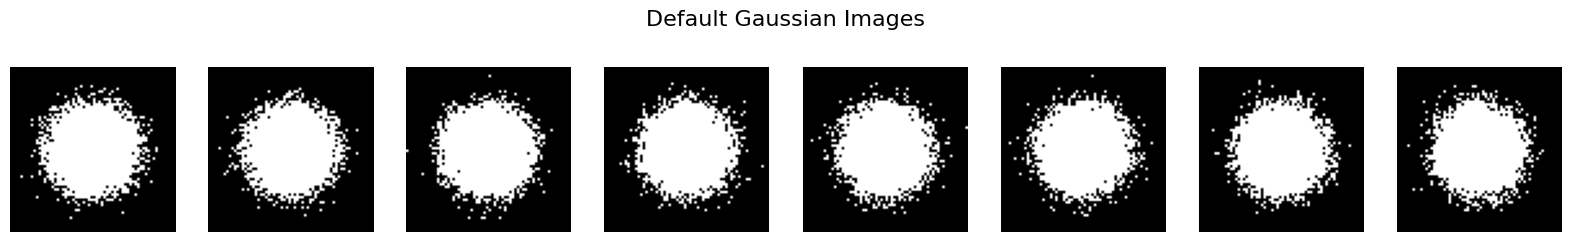

Default Gaussian Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Stretched Gaussian Images...
Generated batch shape: torch.Size([8, 4096])


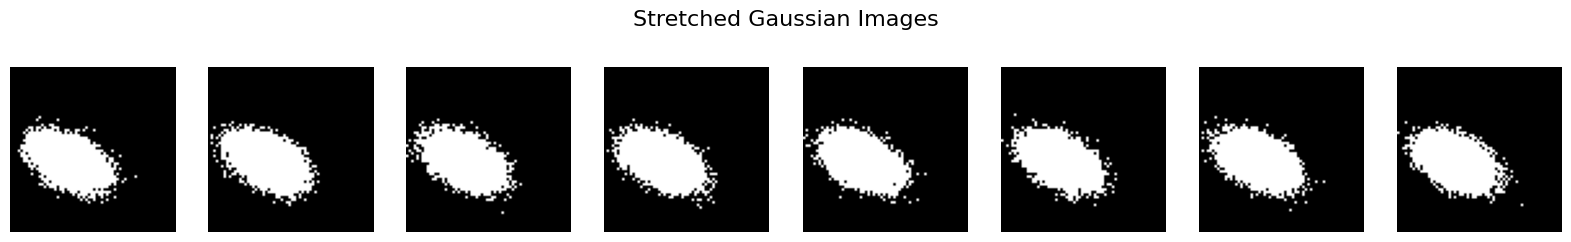

Stretched Gaussian Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Moons Images...
Generated batch shape: torch.Size([8, 4096])


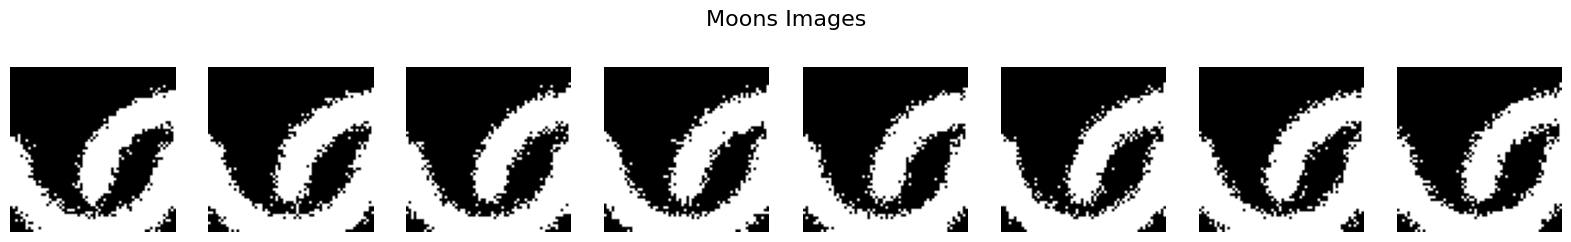

Moons Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Circles Images...
Generated batch shape: torch.Size([8, 4096])


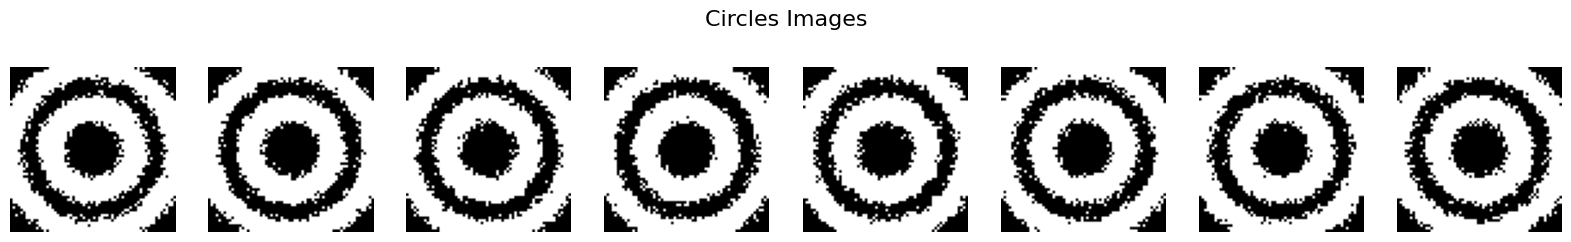

Circles Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Checkerboard Images...
Generated batch shape: torch.Size([8, 4096])


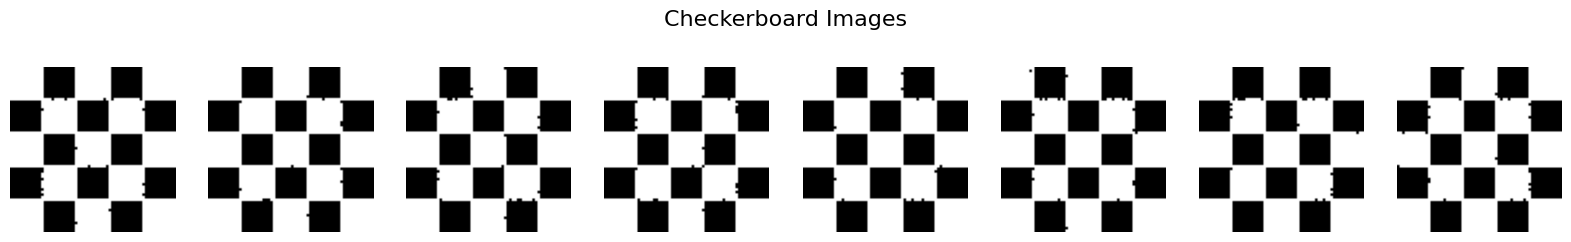

Checkerboard Images dim: 4096, image_shape: (1, 64, 64)

Testing single sample generation (shape and value check):
Single moon image shape: torch.Size([4096]), first few values:
tensor([0., 0., 0., 0.], device='cuda:0')
Single Gaussian image shape: torch.Size([4096]), first few values:
tensor([0., 0., 0., 0.], device='cuda:0')


In [472]:
def visualize_all_samples(
    image_resolution: int = 64,
    points_density: int = 20000,
    num_images_to_show: int = 8,
    device: torch.device = torch.device("cpu")
):
    """
    Initializes and visualizes samples from all Sampleable distributions.

    Args:
        image_resolution: The desired height and width of the square image.
        points_density: The number of underlying 2D points to generate for rendering each image.
        num_images_to_show: The number of images to display from each distribution's batch.
        device: The device (cpu or cuda) to place the generated tensors.
    """
    print(f"Starting visualization on device: {device}\n")

    # Re-define the internal visualization helper to be here, for clarity in this cell
    def _plot_images(sampleable_instance: Sampleable, num_images: int, title: str):
        print(f"Generating {num_images} image samples for {title}...")
        batch_images = sampleable_instance.batch_samples(num_images)
        print(f"Generated batch shape: {batch_images.shape}") # Now will print (num_images, dim)

        display_images = batch_images.cpu()

        plt.figure(figsize=(num_images * 2, 2.5))
        plt.suptitle(title, fontsize=16)

        # Get H and W from image_shape for reshaping
        _, H, W = sampleable_instance.image_shape 

        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            # --- MODIFIED: Reshape flattened image back to (H, W) for imshow ---
            img = display_images[i].reshape(H, W) 
            ax.imshow(img.numpy(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"{title} dim: {sampleable_instance.dim}, image_shape: {sampleable_instance.image_shape}\n")


    # --- Initialize and Visualize each Sampleable Type ---

    # 1. Gaussian Images
    # Default Gaussian (mean=[0,0], cov=I)
    gaussian_sampler_default = GaussianSampleable(device=device, image_size=image_resolution,
                                                  points_per_image=points_density)
    _plot_images(gaussian_sampler_default, num_images_to_show, "Default Gaussian Images")

    # Stretched Gaussian (example with custom mean/covariance)
    stretched_mean = torch.tensor([-2.0, 1.0])
    stretched_covariance = torch.tensor([[1.5, 0.5], [0.5, 0.8]])
    gaussian_sampler_stretched = GaussianSampleable(device=device, image_size=image_resolution,
                                                    mean=stretched_mean, covariance=stretched_covariance,
                                                    scale=7.0, points_per_image=points_density)
    _plot_images(gaussian_sampler_stretched, num_images_to_show, "Stretched Gaussian Images")


    # 2. Moons Images
    moons_sampler = MoonsSampleable(device=device, image_size=image_resolution, noise=0.08,
                                    scale=6.0, points_per_image=points_density)
    _plot_images(moons_sampler, num_images_to_show, "Moons Images")

    # 3. Circles Images
    circles_sampler = CirclesSampleable(device=device, image_size=image_resolution, noise=0.06,
                                        scale=7.0, points_per_image=points_density)
    _plot_images(circles_sampler, num_images_to_show, "Circles Images")

    # 4. Checkerboard Images
    checkerboard_sampler = CheckerboardSampleable(device=device, image_size=image_resolution,
                                                  grid_size=5, scale=6.0, points_per_image=points_density)
    _plot_images(checkerboard_sampler, num_images_to_show, "Checkerboard Images")

    # --- Test single sample generation ---
    print("Testing single sample generation (shape and value check):")
    moon_single_image = moons_sampler.sample()
    print(f"Single moon image shape: {moon_single_image.shape}, first few values:\n{moon_single_image[:4]}") # Display first few flattened values

    gaussian_single_image = gaussian_sampler_default.sample()
    print(f"Single Gaussian image shape: {gaussian_single_image.shape}, first few values:\n{gaussian_single_image[:4]}") # Display first few flattened values

# --- Execute visualization ---
# Choose device (GPU if available, otherwise CPU)
chosen_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the unified visualization function
visualize_all_samples(device=chosen_device)

# Part 2: The Vector Field and the ODE Simulator

In [473]:
class VectorField(ABC):
    @abstractmethod
    def velocity(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), returns: shape(batch_size, dim)
        # imput the position at time t: xt, and the time: t, return the corresponding velocity
        pass

class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), h: shape(batch_size, 1) returns: shape(batch_size, dim)
        # input: the state at time t: t and xt, the step: h
        pass

    @torch.no_grad
    def simulate(self, x: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        # x: shape(batch_size, dim), ts: shape(num_steps,) returns: shape(batch_size, dim)
        # input: the position at ts[0], and the ts. returns: the position at t[-1]

        for time_index in range(ts.shape[0] - 1):
            t = ts[time_index]
            h = ts[time_index + 1] - ts[time_index]
            x = self.step(x, t, h)

        return x

class EulerSimulator(Simulator):
    def __init__(self, vector_field: VectorField):
        self.vector_field = vector_field

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        return xt + self.vector_field.velocity(xt, t) * h

class HeunSimulator(Simulator):
    def __init__(self, vector_field: VectorField):
        self.vector_field = vector_field

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        xt_ = xt + self.vector_field.velocity(xt, t) * h
        return xt + 0.5 * h * (self.vector_field.velocity(xt, t) + self.vector_field.velocity(xt_, t + h))

# Part 3: Construct the Condiaional Gaussian Vector Field

In [474]:
class ConditionalVectorField(ABC):
    @abstractmethod
    def velocity(self, xt: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), z: shape(batch_size, dim)
        # given the xt, t, z, return the velocity
        pass

#### 1. Gaussian conditional probability path:    

A Gaussian conditional probability path is given by

$$p_t(x|z) = N(x;\alpha_t z,\beta_t^2 I_d),\quad\quad\quad p_{\text{simple}}=N(0,I_d),$$

where $\alpha_t: [0,1] \to \mathbb{R}$ and $\beta_t: [0,1] \to \mathbb{R}$ are monotonic, continuously differentiable functions satisfying $\alpha_1 = \beta_0 = 1$ and $\alpha_0 = \beta_1 = 0$. 

In other words, this implies that $p_1(x|z) = \delta_z$ and $p_0(x|z) = N(0, I_d)$ is a unit Gaussian. Before we dive into things, let's take a look at $p_{\text{simple}}$ and $p_{\text{data}}$. 

And simply,

$$X_{t | z} = \alpha_t z + \beta_t X_0$$

In this section, we'll be using 

$$\alpha_t = t \quad \quad \text{and} \quad \quad \beta_t = 1-t.$$

and

$$\alpha_t = t \quad \quad \text{and} \quad \quad \beta_t = \sqrt{1-t}.$$

#### 2. Implement the $\alpha_t$ and $\beta_t$

In [475]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1)), torch.zeros(1, 1))
        assert torch.allclose(self(torch.ones(1, 1)), torch.ones(1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(batch_size, 1)
        pass

    def dt(self, t: torch.Tensor) ->  torch.Tensor:
        # t: shape(batch_size, 1)
        t = t.unsqueeze(1)
        result = vmap(jacrev(self)) (t)
        return result.view(-1, 1)
    
class Beta(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1)), torch.ones(1, 1))
        assert torch.allclose(self(torch.ones(1, 1)), torch.zeros(1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        t = t.unsqueeze(1)
        result = vmap(jacrev(self)) (t)
        return result.view(-1, 1)

The $\alpha_t = t, \quad \beta_t = 1 - t$ set

In [476]:
class LinearAlpha(Alpha):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)

class LinearBeta(Beta):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return - torch.ones_like(t)

The $\alpha_t = t, \quad \beta_t = \sqrt{1 - t}$ set

In [477]:
class SquareRootBeta(Beta):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return torch.sqrt(1 - t)
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -0.5 / ( torch.sqrt(1 - t) + 1e-4)

#### Implement the Gaussian Conditional Vector Field

In [478]:
class GaussianConditionalVectorField(ConditionalVectorField):
    def __init__(self, alpha: Alpha, beta: Beta):
        self.alpha = alpha
        self.beta = beta

    def velocity(self, xt: torch.Tensor, t: float, z: torch.Tensor) -> torch.Tensor:
        d_alpha_t = self.alpha.dt(t)
        d_beta_t = self.beta.dt(t)
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)

        return (d_alpha_t - d_beta_t / beta_t * alpha_t) * z + d_beta_t / beta_t * xt

# Part 4: Build the Nerual Network

Recall now that from lecture that our goal is to learn the *marginal vector field* $u_t(x)$ given by 

$$u_t^{\text{ref}}(x) = \mathbb{E}_{z \sim p_t(z|x)}\left[u_t^{\text{ref}}(x|z)\right].$$

Unfortunately, we don't actually know what $u_t^{\text{ref}}(x)$ is! 

We will thus approximate $u_t^{\text{ref}}(x)$ as a neural network $u_t^{\theta}(x)$, and exploit the identity 

$$ u_t^{\text{ref}}(x) = \text{argmin}_{u_t(x)} \,\,\mathbb{E}_{z \sim p_t(z|x)} \left[\lVert u_t(x) - u_t^{\text{ref}}(x|z)\rVert^2\right]$$ 

to obtain the **conditional flow matching objective**

$$ \mathcal{L}_{\text{CFM}}(\theta) = \,\,\mathbb{E}_{z \sim p(z), x \sim p_t(x|z)} \left[\lVert u_t^{\theta}(x) - u_t^{\text{ref}}(x|z)\rVert^2\right].$$

To model $u_t^{\theta}(x)$, we'll use a simple MLP. This network will take in both $x$ and $t$, and will return the learned vector field $u_t^{\theta}(x)$.


We simulate the loss function: 

$$\mathcal{L}_{\text{CFM}}(\theta) = \,\,\mathbb{E}_{{t \in \mathcal{U}[0,1), z \sim p(z), x \sim p_t(x|z)}} {\lVert u_t^{\theta}(x) - u_t^{\text{ref}}(x|z)\rVert^2}$$

using a Monte-Carlo estimate of the form

$$\frac{1}{N}\sum_{i=1}^N {\lVert u_{t_i}^{\theta}(x_i) - u_{t_i}^{\text{ref}}(x_i|z_i)\rVert^2}, \quad \quad \quad \forall i\in[1, \dots, N]: {\,z_i \sim p_{\text{data}},\, t_i \sim \mathcal{U}[0,1),\, x_i \sim p_t(\cdot | z_i)}.$$

Here, $N$ is our *batch size*.

**For sampling:**
- You can sample `batch_size` points form $p_{\text{data}}$, i.e., get a tensor of `shape (batch_size, dim) from` the `target sampleable class`
- You can sample `batch_size` values of `t` using `torch.rand(batch_size, 1)`.
- You can sample `batch_size` points from $p_{\text{init}}$ , i.e. get a tensor of `shape (batch_size, dim)` form the `initial sampleable class`

**For the loss function:**
- You can access $u_t^{\theta}(x)$ using neural network. In this example, the `torch.nn.Module` class, or more specifically, the `MLPVectorField` class.
- You can access $u_t^{\text{ref}}(x|z)$ using `ConditionalVectorField` class.


In [479]:
def BuildMLP(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
    mlp = []
    for index in range(len(dims) - 1):
        mlp.append(torch.nn.Linear(dims[index], dims[index + 1]))
        if index < len(dims) - 2:
            mlp.append(activation())
    return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    def __init__(self, dim: int = 1 * 64 * 64, hiddens: List[int] = [4096, 2048, 1024, 512]):
        super().__init__()
        self.dim = dim
        self.net = BuildMLP([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # x: shape(batch_size, dim), t: shape(batch_size, 1)
        # return: u_t^theta(x)
        xt = torch.cat([x, t], dim = -1)
        return self.net(xt)

class FlowMatchingTrainer():
    def __init__(self, u_theta: torch.nn.Module, u_t_cond: ConditionalVectorField, p_init: Sampleable , p_data: Sampleable):
        super().__init__()
        self.u_theta = u_theta
        self.u_t_cond = u_t_cond
        self.p_init = p_init
        self.p_data = p_data

    def get_train_loss(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # x: shape(batch_size, dim), t: shape(batch_size, 1), z: shape(batch_size, dim)
        # input the position, time and the condition, return the loss
        v_est = self.u_theta(x, t)
        v_cond = self.u_t_cond.velocity(x, t, z)

        error = torch.norm((v_est - v_cond) , dim=-1) ** 2
        return torch.mean(error)
    
    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.u_theta.parameters(), lr = lr)
    
    def train(self, device: torch.device, num_epochs: int = 100, lr: float = 1e-3, batch_size: int = 128):
        # A batch is considered as an epochs here

        # Start the training
        self.u_theta.to(device)
        opt = self.get_optimizer(lr = lr)
        self.u_theta.train()

        pbar = tqdm(range(num_epochs))
        for index in pbar:
            # get the samples
            z = self.p_data.batch_samples(batch_size).to(device)
            x = self.p_init.batch_samples(batch_size).to(device)
            t = torch.rand(batch_size, 1).to(device)

            # the training process
            opt.zero_grad()
            loss = self.get_train_loss(x, t, z)
            loss.backward()
            opt.step()
            pbar.set_description(f"Epoch {index}, loss: {loss.item(): .6f}")
            print(f"Epoch {index}, loss: {loss.item(): .6f}")

        # Finish the training
        self.u_theta.eval()

In [480]:
class LearnedVectorField(VectorField):
    def __init__(self, model: MLPVectorField):
        self.model = model

    def velocity(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.model(xt, t)

# Part 5: Training

Basic Preparation

In [481]:
# create samplers
standard_gaussian_sampler = GaussianSampleable(device = device)
moonns_sampler = MoonsSampleable(device = device)
circles_sampler = CirclesSampleable(device = device)
checker_board_sampler = CheckerboardSampleable(device = device)
stretched_gaussian_sampler = GaussianSampleable(
    device = device, 
    mean = torch.tensor([-2.0, 1.0]),
    covariance = torch.tensor([[1.5, 0.5], [0.5, 0.8]]),
    scale = 7.0
    )

# create the alpha and beta hucntion
alpha = LinearAlpha()
beta_linear = LinearBeta()
beta_square_root = SquareRootBeta()

# create the conditional gaussian vector field
linear_gaussian_conditional_vector_field = GaussianConditionalVectorField(alpha = alpha, beta = beta_linear)
square_root_gaussian_conditional_vector_field = GaussianConditionalVectorField(alpha = alpha, beta = beta_square_root)

#### 1. Standard Gaussian -> Checker Board

In [482]:
standard_gaussian_to_checker_board_mlp = MLPVectorField()

standard_gaussian_to_checker_board_trainer = FlowMatchingTrainer(
    u_theta = standard_gaussian_to_checker_board_mlp,
    u_t_cond = linear_gaussian_conditional_vector_field,
    p_init = standard_gaussian_sampler,
    p_data = checker_board_sampler
)

standard_gaussian_to_checker_board_trainer.train(device = device)

Epoch 1, loss:  631358.937500:   2%|▏         | 2/100 [00:00<00:11,  8.58it/s]

Epoch 0, loss:  230610.515625
Epoch 1, loss:  631358.937500


Epoch 3, loss:  733520.687500:   4%|▍         | 4/100 [00:00<00:10,  8.75it/s] 

Epoch 2, loss:  1372778.875000
Epoch 3, loss:  733520.687500


Epoch 5, loss:  754526.000000:   6%|▌         | 6/100 [00:00<00:10,  8.87it/s] 

Epoch 4, loss:  1560763.500000
Epoch 5, loss:  754526.000000


Epoch 7, loss:  7789720.500000:   8%|▊         | 8/100 [00:00<00:10,  8.92it/s]

Epoch 6, loss:  959876.625000
Epoch 7, loss:  7789720.500000


Epoch 9, loss:  1832254.375000:  10%|█         | 10/100 [00:01<00:10,  8.96it/s]

Epoch 8, loss:  761242.125000
Epoch 9, loss:  1832254.375000


Epoch 11, loss:  184469.875000:  12%|█▏        | 12/100 [00:01<00:09,  9.01it/s]

Epoch 10, loss:  650947.250000
Epoch 11, loss:  184469.875000


Epoch 13, loss:  686002.875000:  14%|█▍        | 14/100 [00:01<00:09,  9.02it/s] 

Epoch 12, loss:  1233665.500000
Epoch 13, loss:  686002.875000


Epoch 15, loss:  23225574.000000:  16%|█▌        | 16/100 [00:01<00:09,  9.01it/s]

Epoch 14, loss:  266378.906250
Epoch 15, loss:  23225574.000000


Epoch 17, loss:  326223.281250:  18%|█▊        | 18/100 [00:02<00:09,  9.04it/s]  

Epoch 16, loss:  2088589.250000
Epoch 17, loss:  326223.281250


Epoch 19, loss:  477141888.000000:  20%|██        | 20/100 [00:02<00:08,  9.06it/s]

Epoch 18, loss:  58605780.000000
Epoch 19, loss:  477141888.000000


Epoch 21, loss:  2031608.250000:  22%|██▏       | 22/100 [00:02<00:08,  9.05it/s]  

Epoch 20, loss:  41170316.000000
Epoch 21, loss:  2031608.250000


Epoch 23, loss:  28093358.000000:  24%|██▍       | 24/100 [00:02<00:08,  9.06it/s]

Epoch 22, loss:  390820.343750
Epoch 23, loss:  28093358.000000


Epoch 25, loss:  3132361.000000:  26%|██▌       | 26/100 [00:02<00:08,  9.06it/s] 

Epoch 24, loss:  4502253.500000
Epoch 25, loss:  3132361.000000


Epoch 27, loss:  568118.937500:  28%|██▊       | 28/100 [00:03<00:07,  9.03it/s] 

Epoch 26, loss:  690269.625000
Epoch 27, loss:  568118.937500


Epoch 29, loss:  74163.351562:  30%|███       | 30/100 [00:03<00:07,  9.04it/s] 

Epoch 28, loss:  339052.906250
Epoch 29, loss:  74163.351562


Epoch 31, loss:  451374.406250:  32%|███▏      | 32/100 [00:03<00:07,  9.02it/s] 

Epoch 30, loss:  1006500.937500
Epoch 31, loss:  451374.406250


Epoch 33, loss:  1257411.750000:  34%|███▍      | 34/100 [00:03<00:07,  8.93it/s]

Epoch 32, loss:  529896.812500
Epoch 33, loss:  1257411.750000


Epoch 35, loss:  907484.312500:  36%|███▌      | 36/100 [00:04<00:07,  8.99it/s]  

Epoch 34, loss:  55313216.000000
Epoch 35, loss:  907484.312500


Epoch 37, loss:  330144928.000000:  38%|███▊      | 38/100 [00:04<00:06,  9.00it/s]

Epoch 36, loss:  2457125.250000
Epoch 37, loss:  330144928.000000


Epoch 39, loss:  502674.437500:  40%|████      | 40/100 [00:04<00:06,  9.02it/s]   

Epoch 38, loss:  1875665.875000
Epoch 39, loss:  502674.437500


Epoch 41, loss:  184237104.000000:  42%|████▏     | 42/100 [00:04<00:06,  9.00it/s]

Epoch 40, loss:  11823086.000000
Epoch 41, loss:  184237104.000000


Epoch 43, loss:  469384.250000:  44%|████▍     | 44/100 [00:04<00:06,  9.02it/s]   

Epoch 42, loss:  12110713.000000
Epoch 43, loss:  469384.250000


Epoch 45, loss:  600143.312500:  46%|████▌     | 46/100 [00:05<00:05,  9.02it/s] 

Epoch 44, loss:  2275440.250000
Epoch 45, loss:  600143.312500


Epoch 47, loss:  3015243.250000:  48%|████▊     | 48/100 [00:05<00:05,  9.01it/s]

Epoch 46, loss:  1463699.875000
Epoch 47, loss:  3015243.250000


Epoch 49, loss:  148067.250000:  50%|█████     | 50/100 [00:05<00:05,  9.00it/s] 

Epoch 48, loss:  5949583.000000
Epoch 49, loss:  148067.250000


Epoch 51, loss:  2985332.000000:  52%|█████▏    | 52/100 [00:05<00:05,  9.01it/s]

Epoch 50, loss:  6998612.000000
Epoch 51, loss:  2985332.000000


Epoch 53, loss:  5174468.500000:  54%|█████▍    | 54/100 [00:06<00:05,  9.00it/s]  

Epoch 52, loss:  147615568.000000
Epoch 53, loss:  5174468.500000


Epoch 55, loss:  1013799.875000:  56%|█████▌    | 56/100 [00:06<00:04,  9.01it/s] 

Epoch 54, loss:  52306468.000000
Epoch 55, loss:  1013799.875000


Epoch 57, loss:  1839252.500000:  58%|█████▊    | 58/100 [00:06<00:04,  9.03it/s]

Epoch 56, loss:  1358588.125000
Epoch 57, loss:  1839252.500000


Epoch 59, loss:  1803997.250000:  60%|██████    | 60/100 [00:06<00:04,  9.02it/s]  

Epoch 58, loss:  116453912.000000
Epoch 59, loss:  1803997.250000


Epoch 61, loss:  29500310.000000:  62%|██████▏   | 62/100 [00:06<00:04,  9.02it/s] 

Epoch 60, loss:  524432448.000000
Epoch 61, loss:  29500310.000000


Epoch 63, loss:  642409.375000:  64%|██████▍   | 64/100 [00:07<00:03,  9.02it/s]  

Epoch 62, loss:  858073.375000
Epoch 63, loss:  642409.375000


Epoch 65, loss:  555419.437500:  66%|██████▌   | 66/100 [00:07<00:03,  9.02it/s] 

Epoch 64, loss:  1629013.875000
Epoch 65, loss:  555419.437500


Epoch 67, loss:  4575707.000000:  68%|██████▊   | 68/100 [00:07<00:03,  9.01it/s]

Epoch 66, loss:  6502424.000000
Epoch 67, loss:  4575707.000000


Epoch 69, loss:  40964316.000000:  70%|███████   | 70/100 [00:07<00:03,  9.02it/s]

Epoch 68, loss:  232211.421875
Epoch 69, loss:  40964316.000000


Epoch 71, loss:  161438288.000000:  72%|███████▏  | 72/100 [00:08<00:03,  9.03it/s]

Epoch 70, loss:  355466.531250
Epoch 71, loss:  161438288.000000


Epoch 73, loss:  90457144.000000:  74%|███████▍  | 74/100 [00:08<00:02,  9.01it/s] 

Epoch 72, loss:  202543952.000000
Epoch 73, loss:  90457144.000000


Epoch 75, loss:  1808592.750000:  76%|███████▌  | 76/100 [00:08<00:02,  9.00it/s] 

Epoch 74, loss:  950470.687500
Epoch 75, loss:  1808592.750000


Epoch 77, loss:  762715.625000:  78%|███████▊  | 78/100 [00:08<00:02,  9.00it/s] 

Epoch 76, loss:  1611284.750000
Epoch 77, loss:  762715.625000


Epoch 79, loss:  344252.093750:  80%|████████  | 80/100 [00:08<00:02,  9.01it/s] 

Epoch 78, loss:  3070280.000000
Epoch 79, loss:  344252.093750


Epoch 81, loss:  13957028.000000:  82%|████████▏ | 82/100 [00:09<00:01,  9.02it/s]

Epoch 80, loss:  183440.296875
Epoch 81, loss:  13957028.000000


Epoch 83, loss:  6345909.000000:  84%|████████▍ | 84/100 [00:09<00:01,  8.99it/s] 

Epoch 82, loss:  36116696.000000
Epoch 83, loss:  6345909.000000


Epoch 85, loss:  388999.218750:  86%|████████▌ | 86/100 [00:09<00:01,  8.97it/s] 

Epoch 84, loss:  212546.125000
Epoch 85, loss:  388999.218750


Epoch 87, loss:  5268953.500000:  88%|████████▊ | 88/100 [00:09<00:01,  8.99it/s]

Epoch 86, loss:  5372814.000000
Epoch 87, loss:  5268953.500000


Epoch 89, loss:  818893.937500:  90%|█████████ | 90/100 [00:10<00:01,  8.98it/s] 

Epoch 88, loss:  483598.625000
Epoch 89, loss:  818893.937500


Epoch 91, loss:  1552509.250000:  92%|█████████▏| 92/100 [00:10<00:00,  9.00it/s]

Epoch 90, loss:  1708303.750000
Epoch 91, loss:  1552509.250000


Epoch 93, loss:  5484903.000000:  94%|█████████▍| 94/100 [00:10<00:00,  9.00it/s]

Epoch 92, loss:  6580474.500000
Epoch 93, loss:  5484903.000000


Epoch 95, loss:  266884.500000:  96%|█████████▌| 96/100 [00:10<00:00,  9.00it/s]  

Epoch 94, loss:  26872574.000000
Epoch 95, loss:  266884.500000


Epoch 97, loss:  510539.343750:  98%|█████████▊| 98/100 [00:10<00:00,  9.01it/s]

Epoch 96, loss:  281451.187500
Epoch 97, loss:  510539.343750


Epoch 99, loss:  329711.937500: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]

Epoch 98, loss:  7100593.000000
Epoch 99, loss:  329711.937500


# Part6: Simulation and Visualization

In [483]:
learned_standard_gaussian_to_checker_board_vector_field = LearnedVectorField(
    model = standard_gaussian_to_checker_board_mlp
)

euler_simulator = EulerSimulator(learned_standard_gaussian_to_checker_board_vector_field)
x_init = standard_gaussian_sampler.sample()
ts = torch.linspace(0.0, 1.0, 1000, device=device).unsqueeze(-1)
x_final = euler_simulator.simulate(x_init, ts)
print(x_final.shape)
x_checker_board = checker_board_sampler.sample()

torch.Size([4096])


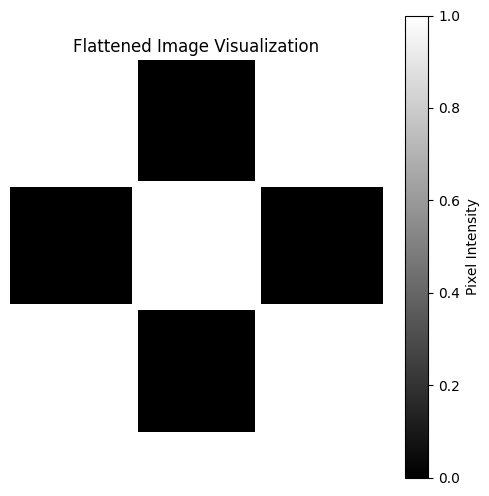

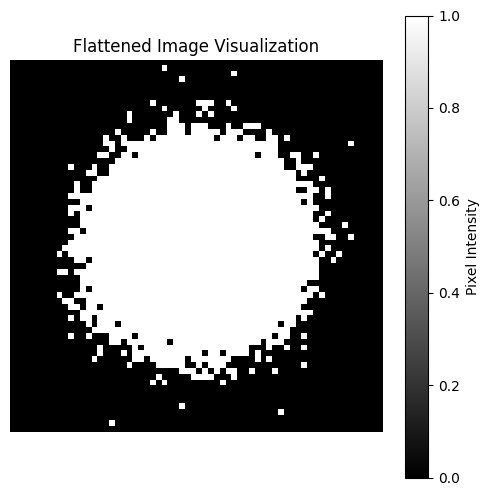

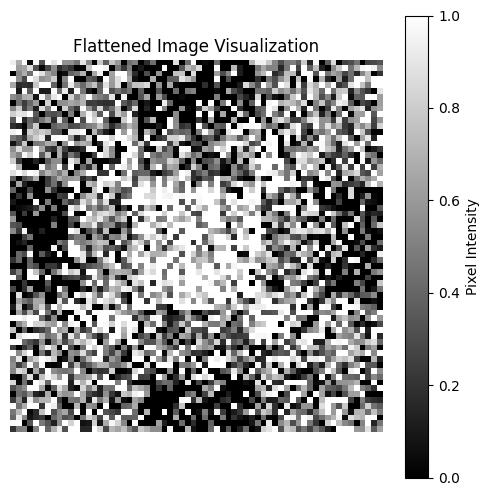

In [484]:
visualize_flattened_image(x_checker_board)
visualize_flattened_image(x_init)
visualize_flattened_image(x_final)